In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import re

In [2]:
# Φορτώνω το αρχείο με τα δεδομένα (train)
df = pd.read_csv("train.csv",low_memory=False)

In [5]:
print("Μέγεθος πίνακα:", df.shape)
print("Πρώτες γραμμές:\n", df.head())

Μέγεθος πίνακα: (100000, 28)
Πρώτες γραμμές:
        ID Customer_ID     Month           Name   Age          SSN Occupation  \
0  0x1602   CUS_0xd40   January  Aaron Maashoh    23  821-00-0265  Scientist   
1  0x1603   CUS_0xd40  February  Aaron Maashoh    23  821-00-0265  Scientist   
2  0x1604   CUS_0xd40     March  Aaron Maashoh  -500  821-00-0265  Scientist   
3  0x1605   CUS_0xd40     April  Aaron Maashoh    23  821-00-0265  Scientist   
4  0x1606   CUS_0xd40       May  Aaron Maashoh    23  821-00-0265  Scientist   

  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  Credit_Mix  \
0      19114.12            1824.843333                  3  ...           _   
1      19114.12                    NaN                  3  ...        Good   
2      19114.12                    NaN                  3  ...        Good   
3      19114.12                    NaN                  3  ...        Good   
4      19114.12            1824.843333                  3  ...        Good   

   O

In [7]:
# Aφαίρεση μη κατάλληλων χαρακτήρων
columns_to_clean = [
    'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
    'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
    'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
    'Amount_invested_monthly', 'Monthly_Balance', 'Age', 'Total_EMI_per_month'
]

for col in columns_to_clean:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(r'[^0-9.\-]', '', regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Επιδιόρθωση ηλικίας
valid_age = df['Age'][(df['Age'] >= 18) & (df['Age'] <= 100)]
avg_age = round(valid_age.mean())
df['Age'] = df['Age'].apply(lambda x: avg_age if pd.isna(x) or x < 18 or x > 100 else x)

# Συμπεριφορά πληρωμής διόρθωση
df['Payment_Behaviour'] = df['Payment_Behaviour'].apply(
    lambda x: x if isinstance(x, str) and 'spent' in x.lower() else np.nan
)

# Αντικατάσταση περίεργων τιμών
df['Occupation'] = df['Occupation'].replace(['_______', '_____'], np.nan)
df['Type_of_Loan'] = df['Type_of_Loan'].replace('Not Specified', np.nan)

# Διόρθωση SSN
def valid_ssn(x):
    if isinstance(x, str) and re.fullmatch(r'\d{3}-\d{2}-\d{4}', x):
        return x
    return np.nan

df['SSN'] = df['SSN'].apply(valid_ssn)

# Διόρθωση τιμών από στήλες
df['Num_Credit_Card'] = df['Num_Credit_Card'].apply(lambda x: x if 0 <= x <= 20 else np.nan)
df['Num_of_Loan'] = df['Num_of_Loan'].apply(lambda x: x if 0 <= x <= 20 else np.nan)
df['Interest_Rate'] = df['Interest_Rate'].apply(lambda x: x if 0 <= x <= 100 else np.nan)
df['Delay_from_due_date'] = df['Delay_from_due_date'].apply(lambda x: x if 0 <= x <= 60 else np.nan)

# Αντικατάσταση μη έγκυρων τιμών στις πληρωμές
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].apply(
    lambda x: x if x in ['Yes', 'No'] else np.nan
)

# Συμπλήρωση κενών
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].fillna(df[column].mode()[0])
    else:
        df[column] = df[column].fillna(df[column].mean())

# Μετατροπή σε ακέραια όπου έχει νόημα
for c in ['Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date']:
    if c in df.columns:
        df[c] = df[c].round().astype(int)

# Εμφάνιση δείγματος
print("\nΔείγμα καθαρισμένων δεδομένων:")
print(df.head(100))



Δείγμα καθαρισμένων δεδομένων:
        ID Customer_ID     Month             Name  Age          SSN  \
0   0x1602   CUS_0xd40   January    Aaron Maashoh   23  821-00-0265   
1   0x1603   CUS_0xd40  February    Aaron Maashoh   23  821-00-0265   
2   0x1604   CUS_0xd40     March    Aaron Maashoh   34  821-00-0265   
3   0x1605   CUS_0xd40     April    Aaron Maashoh   23  821-00-0265   
4   0x1606   CUS_0xd40       May    Aaron Maashoh   23  821-00-0265   
..     ...         ...       ...              ...  ...          ...   
95  0x168d  CUS_0xc0ab    August         Soyoungd   33  342-90-2649   
96  0x1692  CUS_0x3e45   January  Harriet McLeodd   35  414-53-2918   
97  0x1693  CUS_0x3e45  February  Harriet McLeodd   35  414-53-2918   
98  0x1694  CUS_0x3e45     March  Harriet McLeodd   35  000-08-1349   
99  0x1695  CUS_0x3e45     April  Harriet McLeodd   35  414-53-2918   

      Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0      Scientist       19114.12       

In [9]:
# Δημιουργία λίστας με μοναδικά Customer_IDs
customer_ids = df['Customer_ID'].unique()
data = []

# Νέες στήλες
columns = [
    "interest_rate_max", "interest_rate_min", "avg_interest_rate",
    "avg_debt", "avg_delay_from_due_date", "age", "avg_income",
    "avg_inhand_salary", "avg_monthly_balance", "avg_num_bank_accounts",
    "avg_num_credit_cards", "avg_num_loans", "avg_num_delayed_payments",
    "avg_emi", "avg_credit_utilization", "avg_credit_history_age",
    "avg_changed_credit_limit", "avg_investment", "occupation",
    "type_of_loan", "credit_mix", "payment_behaviour", "credit_score"
]

# Υπολογισμός για κάθε πελάτη
for cust_id in customer_ids:
    subset = df[df['Customer_ID'] == cust_id]

    row = [
        subset['Interest_Rate'].max(),
        subset['Interest_Rate'].min(),
        subset['Interest_Rate'].mean(),
        subset['Outstanding_Debt'].mean(),
        subset['Delay_from_due_date'].mean(),
        subset['Age'].max(),
        subset['Annual_Income'].mean(),
        subset['Monthly_Inhand_Salary'].mean(),
        subset['Monthly_Balance'].mean(),
        subset['Num_Bank_Accounts'].mean(),
        subset['Num_Credit_Card'].mean(),
        subset['Num_of_Loan'].mean(),
        subset['Num_of_Delayed_Payment'].mean(),
        subset['Total_EMI_per_month'].mean(),
        subset['Credit_Utilization_Ratio'].mean(),
        subset['Credit_History_Age'].mean(),
        subset['Changed_Credit_Limit'].mean(),
        subset['Amount_invested_monthly'].mean(),
        subset['Occupation'].mode()[0],
        subset['Type_of_Loan'].mode()[0],
        subset['Credit_Mix'].mode()[0],
        subset['Payment_Behaviour'].mode()[0],
        subset['Credit_Score'].mode()[0]
    ]

    data.append(row)

# Δημιουργία τελικού DataFrame
final_df = pd.DataFrame(data, columns=columns)

# Προβολή δείγματος
print(final_df.head(10))


   interest_rate_max  interest_rate_min  avg_interest_rate  avg_debt  \
0           3.000000                3.0           3.000000    809.98   
1           6.000000                6.0           6.000000    605.03   
2           8.000000                8.0           8.000000   1303.01   
3           4.000000                4.0           4.000000    632.46   
4           5.000000                5.0           5.000000    943.86   
5          14.546679                8.0           8.818335    548.20   
6           8.000000                8.0           8.000000    352.16   
7          15.000000               15.0          15.000000   1704.18   
8           7.000000                7.0           7.000000   1377.74   
9          12.000000               12.0          12.000000    421.43   

   avg_delay_from_due_date  age  avg_income  avg_inhand_salary  \
0                    6.500   34    19114.12        3009.507091   
1                    3.500   28    34847.84        3327.032712   
2        

In [11]:
# φόρτωση κατάλληλων πακέτων
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
#διαχωρισμός στηλών
numeric_cols = final_df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = final_df.select_dtypes(include=['object']).columns.tolist()

In [15]:
#Βασικά στατιστικά για τις αριθμητικές στήλες
print("Basic stats for numeric columns:")
print(final_df[numeric_cols].describe())

Basic stats for numeric columns:
       interest_rate_max  interest_rate_min  avg_interest_rate      avg_debt  \
count       12500.000000       12500.000000       12500.000000  12500.000000   
mean           15.203959          13.972415          14.546679   1426.220376   
std             8.894379           8.330444           8.579898   1155.169458   
min             1.000000           1.000000           1.000000      0.230000   
25%             8.000000           7.000000           7.943335    566.072500   
50%            14.546679          13.000000          13.000000   1166.155000   
75%            20.000000          19.000000          20.000000   1945.962500   
max           100.000000          34.000000          39.875000   4998.070000   

       avg_delay_from_due_date          age    avg_income  avg_inhand_salary  \
count             12500.000000  12500.00000  1.250000e+04       12500.000000   
mean                 20.671310     35.49920  1.764157e+05        4194.170850   
std   

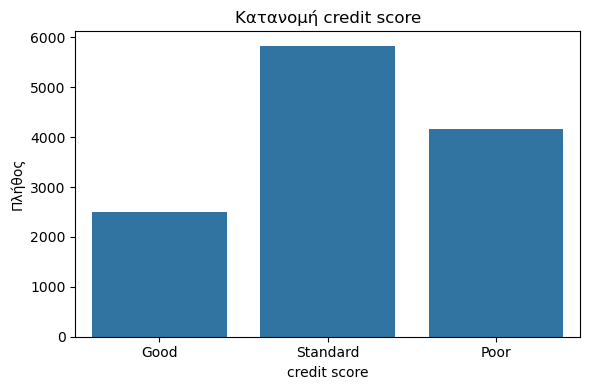

In [17]:
#Countplot credit score
plt.figure(figsize=(6,4))
sns.countplot(x='credit_score', data=final_df)
plt.title('Κατανομή credit score')
plt.xlabel('credit score')
plt.ylabel('Πλήθος')
plt.tight_layout()
plt.show()

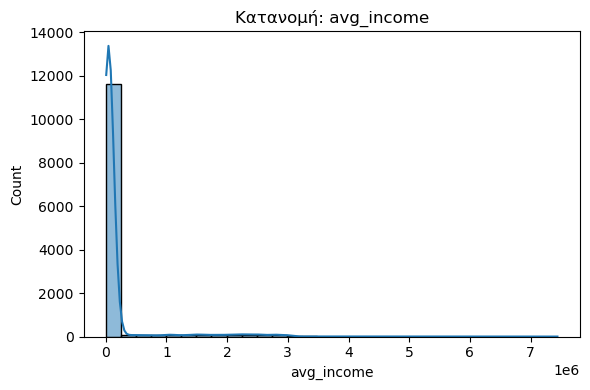

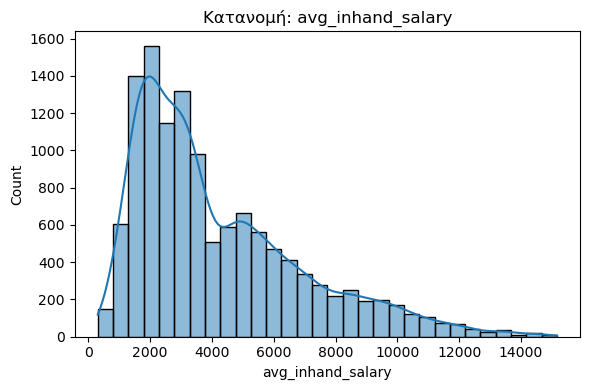

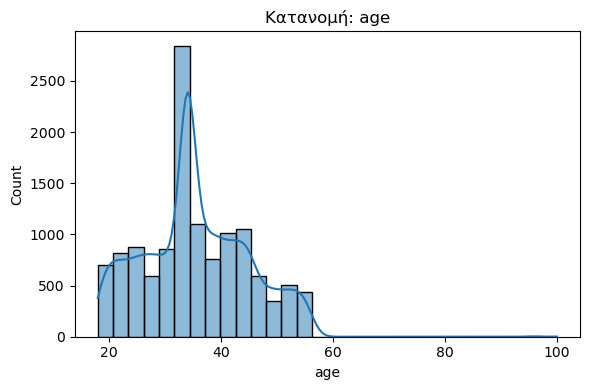

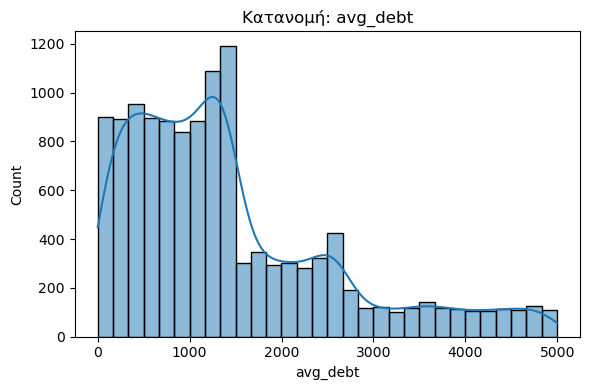

In [19]:
# Ιστόγραμμα για αριθμητικές μεταβλητές στο final_df
to_plot = ['avg_income', 'avg_inhand_salary', 'age', 'avg_debt']

for col in to_plot:
    plt.figure(figsize=(6,4))
    sns.histplot(final_df[col], bins=30, kde=True)
    plt.title(f'Κατανομή: {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

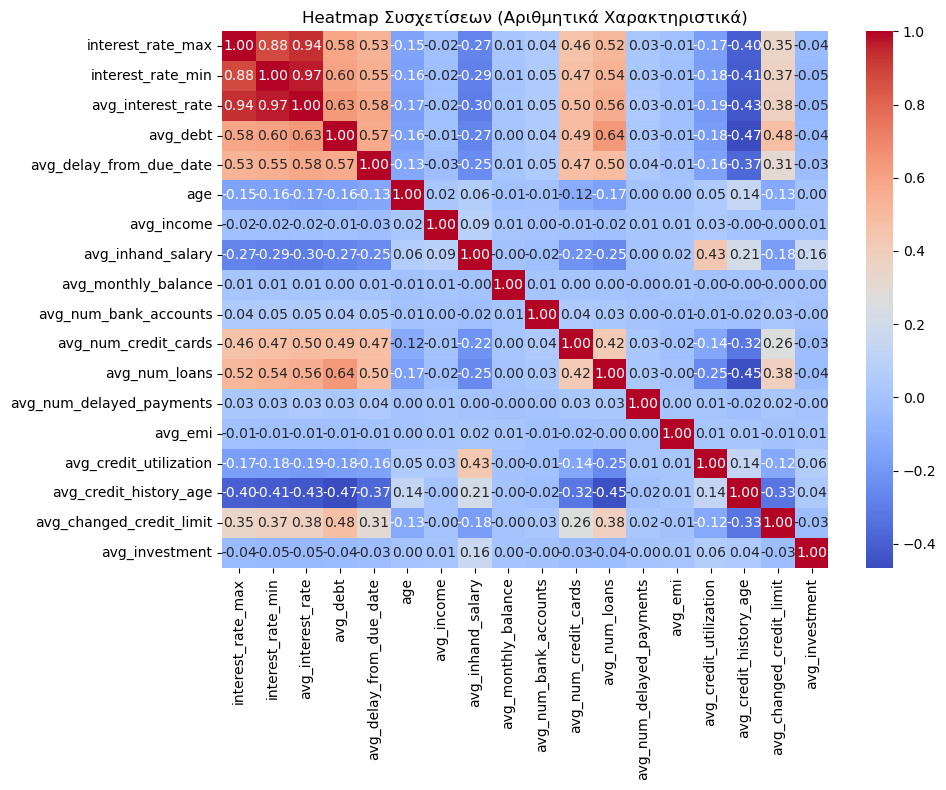

In [20]:
# Επιλογή μόνο των αριθμητικών στηλών από το final_df
numeric_cols = final_df.select_dtypes(include=['int64', 'float64']).columns

# Υπολογισμός συσχετίσεων Pearson
corr_mat = final_df[numeric_cols].corr()

# Plot του heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Heatmap Συσχετίσεων (Αριθμητικά Χαρακτηριστικά)')
plt.tight_layout()
plt.show()

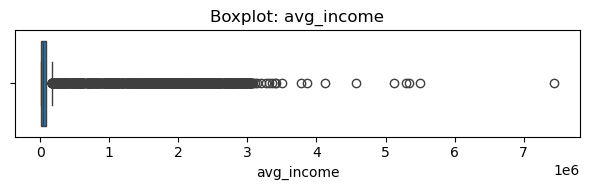

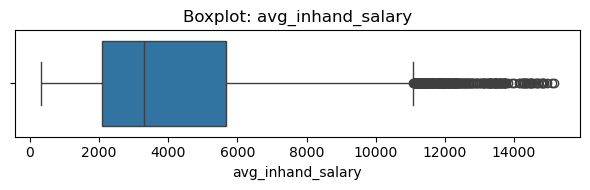

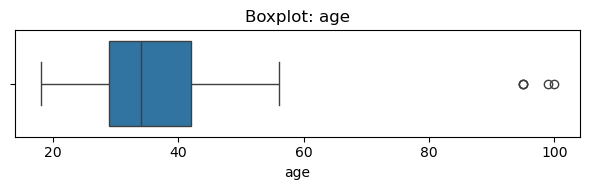

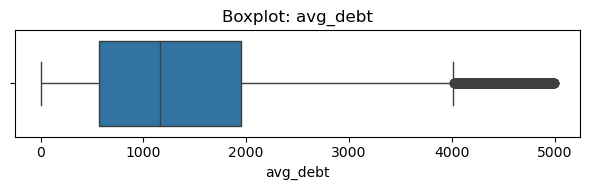

In [23]:
# Επιλογή αριθμητικών στηλών 
to_plot = ['avg_income', 'avg_inhand_salary', 'age', 'avg_debt']

# Boxplots για τον εντοπισμό outliers
for col in to_plot:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=final_df[col])
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

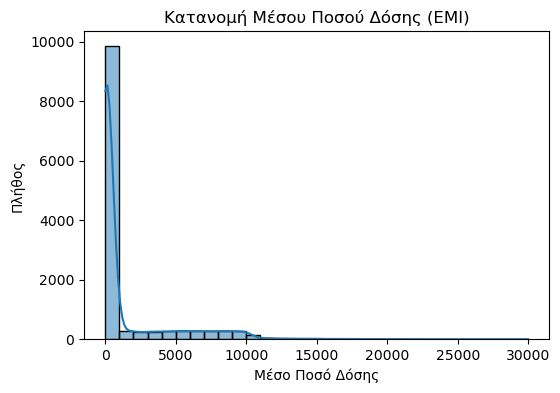

In [25]:
plt.figure(figsize=(6,4))
sns.histplot(final_df['avg_emi'], bins=30, kde=True)
plt.title('Κατανομή Μέσου Ποσού Δόσης (EMI)')
plt.xlabel('Μέσο Ποσό Δόσης')
plt.ylabel('Πλήθος')
plt.show()

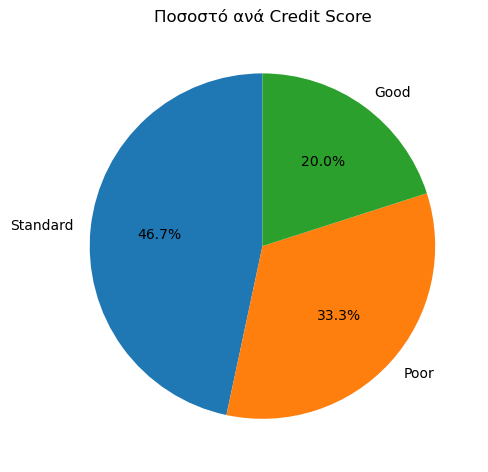

In [27]:
#Pie chart για ποσοστά Credit_Score
counts = final_df['credit_score'].value_counts()
plt.figure(figsize=(5,5))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Ποσοστό ανά Credit Score')
plt.tight_layout()
plt.show()

In [29]:
# Επιλογή αριθμητικών στηλών από το final_df
numeric_cols = final_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Μετατροπή της κατηγορικής στήλης credit_score σε αριθμητική
final_df['CS_numeric'] = final_df['credit_score'].map({'Poor': 0, 'Standard': 1, 'Good': 2})

# Υπολογισμός συσχετίσεων Pearson μεταξύ αριθμητικών στηλών και του credit score
corr_with_target = final_df[numeric_cols + ['CS_numeric']].corr()['CS_numeric'].drop('CS_numeric')

# Ταξινόμηση των συσχετίσεων από το πιο θετικό στο πιο αρνητικό
corr_with_target = corr_with_target.sort_values(ascending=False)

# Εμφάνιση αποτελεσμάτων
print("\nCorrelations with Credit Score (numeric):")
print(corr_with_target)


Correlations with Credit Score (numeric):
avg_credit_history_age      0.315290
avg_inhand_salary           0.229417
avg_credit_utilization      0.145088
age                         0.140918
avg_investment              0.034784
avg_emi                     0.029723
avg_income                  0.023103
avg_monthly_balance        -0.009058
avg_num_delayed_payments   -0.034273
avg_num_bank_accounts      -0.036048
avg_changed_credit_limit   -0.191224
avg_num_loans              -0.390890
avg_debt                   -0.424638
avg_num_credit_cards       -0.444706
avg_delay_from_due_date    -0.471578
interest_rate_max          -0.484933
interest_rate_min          -0.506197
avg_interest_rate          -0.530230
Name: CS_numeric, dtype: float64


In [31]:
keep = [
    # Τα πιο σημαντικά αριθμητικά features
    'avg_interest_rate',
    'avg_delay_from_due_date',
    'avg_debt',
    'avg_num_loans',
    'avg_num_credit_cards',
    'avg_credit_history_age',
    'avg_inhand_salary',
    'avg_credit_utilization',
    'age',
    # Target
    'credit_score'
]

# Προσθέτουμε και τις βασικές κατηγορικές
categoricals = ['occupation', 'type_of_loan', 'credit_mix', 'payment_behaviour']

In [33]:
# φτιάχνουμε το df model
df_model = final_df[keep + categoricals]

In [35]:
#Μετατροπή των κατηγορικών σε αριθμούς
df_model = pd.get_dummies(
    df_model,
    columns=categoricals,
    drop_first=True
)

In [37]:
#φόρτωση κατάλληλων πακέτων για λογιστικ΄ή παλινδρόμιση 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
#διαχωρισμός x και y
y = df_model['credit_score'].map({'Poor':0, 'Standard':1, 'Good':2})
X = df_model.drop('credit_score', axis=1)

In [39]:
#εκπαίδευση train και test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y      # διατηρεί την κατανομή των 3 κλάσεων
)

In [41]:
#scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # μαθαίνει mean/std από train
X_test_scaled  = scaler.transform(X_test)       # εφαρμόζει την ίδια κλίμακα στο test

In [43]:
# Εκπαίδευση LG
clf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  
    random_state=42
)
clf.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [45]:
#Αξιολόγηση
y_pred = clf.predict(X_test_scaled)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Poor','Standard','Good']))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

        Poor       0.64      0.64      0.64       832
    Standard       0.72      0.60      0.66      1167
        Good       0.53      0.75      0.62       501

    accuracy                           0.64      2500
   macro avg       0.63      0.66      0.64      2500
weighted avg       0.66      0.64      0.64      2500

=== Confusion Matrix ===
[[531 177 124]
 [262 699 206]
 [ 35  90 376]]


In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=['Poor','Standard','Good']))

              precision    recall  f1-score   support

        Poor       0.70      0.72      0.71       832
    Standard       0.85      0.62      0.72      1167
        Good       0.56      0.88      0.69       501

    accuracy                           0.71      2500
   macro avg       0.70      0.74      0.71      2500
weighted avg       0.74      0.71      0.71      2500



In [49]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
param_dist = {
    'n_estimators': [100, 200, 300],           # αριθμός δέντρων
    'max_depth': [10, 20, 30, None],           # μέγιστο βάθος δέντρων
    'min_samples_split': [2, 5, 10],           # ελάχιστα δείγματα για split
    'min_samples_leaf': [1, 2, 4],             # ελάχιστα δείγματα σε φύλλα
    'max_features': ['sqrt', 'log2']           # πόσα features να δοκιμάζει σε κάθε split
}

In [51]:
rf = RandomForestClassifier(random_state=42)

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,                # 10 διαφορετικοί συνδυασμοί
    cv=3,                     # 3-fold cross-validation
    scoring='f1_macro',       # balanced performance για τις 3 κατηγορίες
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [53]:
best_rf = search.best_estimator_

y_pred = best_rf.predict(X_test)

print("\n=== Καλύτερες παραμέτροι ===")
print(search.best_params_)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Poor', 'Standard', 'Good']))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


=== Καλύτερες παραμέτροι ===
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}

=== Classification Report ===
              precision    recall  f1-score   support

        Poor       0.71      0.68      0.70       832
    Standard       0.79      0.65      0.71      1167
        Good       0.57      0.84      0.68       501

    accuracy                           0.70      2500
   macro avg       0.69      0.73      0.70      2500
weighted avg       0.72      0.70      0.70      2500


=== Confusion Matrix ===
[[569 130 133]
 [223 762 182]
 [  7  73 421]]


In [59]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 3.7 MB/s eta 0:00:40
   ---------------------------------------- 1.6/150.0 MB 3.8 MB/s eta 0:00:39
    --------------------------------------- 2.4/150.0 MB 3.7 MB/s eta 0:00:40
    --------------------------------------- 3.1/150.0 MB 3.6 MB/s eta 0:00:41
   - -------------------------------------- 3.9/150.0 MB 3.7 MB/s eta 0:00:40
   - -------------------------------------- 4.7/150.0 MB 3.9 MB/s eta 0:00:38
   - -------------------------------------- 6.0/150.0 MB 4.1 MB/s eta 0:00:36
   - -------------------------------------- 6.8/150.0 MB 4.1 MB/s eta 0:00:36
   -- ------------------------------------- 7.9/150.0 MB 4.2 MB/s eta 0:00:34
   -- ------------------------------------- 8.4/150.0 MB 4.0 MB/s eta 0:00:36
   -- ------------------------------------- 8.7/150.0 MB 3.8 MB/s eta 0:00:38


In [61]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=3,
    random_state=42
)
xgb_clf.fit(X_train_scaled, y_train)
y_pred = xgb_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=['Poor','Standard','Good']))

              precision    recall  f1-score   support

        Poor       0.71      0.73      0.72       832
    Standard       0.77      0.69      0.73      1167
        Good       0.62      0.72      0.67       501

    accuracy                           0.71      2500
   macro avg       0.70      0.72      0.70      2500
weighted avg       0.72      0.71      0.71      2500



In [63]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(64,32),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)
y_pred2 = mlp.predict(X_test_scaled)
print(classification_report(y_test, y_pred2, target_names=['Poor','Standard','Good']))

              precision    recall  f1-score   support

        Poor       0.59      0.69      0.63       832
    Standard       0.67      0.58      0.62      1167
        Good       0.53      0.54      0.54       501

    accuracy                           0.61      2500
   macro avg       0.60      0.60      0.60      2500
weighted avg       0.61      0.61      0.61      2500



In [65]:
mlp = MLPClassifier(
    hidden_layer_sizes=(128,64),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    alpha=1e-4,
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)

print(classification_report(y_test, y_pred, target_names=['Poor','Standard','Good']))

              precision    recall  f1-score   support

        Poor       0.64      0.67      0.65       832
    Standard       0.70      0.62      0.66      1167
        Good       0.55      0.67      0.60       501

    accuracy                           0.65      2500
   macro avg       0.63      0.65      0.64      2500
weighted avg       0.65      0.65      0.65      2500

